## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST, None,'d:\.fastai/data')

In [4]:
path.ls()

[WindowsPath('d:/.fastai/data/mnist_png/models'),
 WindowsPath('d:/.fastai/data/mnist_png/testing'),
 WindowsPath('d:/.fastai/data/mnist_png/training')]

In [5]:
il = ImageList.from_folder(path, convert_mode='L') #'L' is grayscale, 'P' is palettised image. detail in PIL library
doc(ImageList)

In [6]:
il.items[0]

WindowsPath('d:/.fastai/data/mnist_png/testing/0/10.png')

In [7]:
defaults.cmap='binary' #matplotlib library

In [8]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: d:\.fastai\data\mnist_png

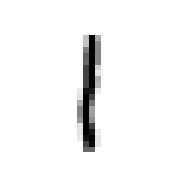

In [9]:
il[1001].show()

In [10]:
sd = il.split_by_folder(train='training', valid='testing')

In [11]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: d:\.fastai\data\mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: d:\.fastai\data\mnist_png;

Test: None

In [12]:
(path/'training').ls(), (path/'testing').ls()

([WindowsPath('d:/.fastai/data/mnist_png/training/0'),
  WindowsPath('d:/.fastai/data/mnist_png/training/1'),
  WindowsPath('d:/.fastai/data/mnist_png/training/2'),
  WindowsPath('d:/.fastai/data/mnist_png/training/3'),
  WindowsPath('d:/.fastai/data/mnist_png/training/4'),
  WindowsPath('d:/.fastai/data/mnist_png/training/5'),
  WindowsPath('d:/.fastai/data/mnist_png/training/6'),
  WindowsPath('d:/.fastai/data/mnist_png/training/7'),
  WindowsPath('d:/.fastai/data/mnist_png/training/8'),
  WindowsPath('d:/.fastai/data/mnist_png/training/9')],
 [WindowsPath('d:/.fastai/data/mnist_png/testing/0'),
  WindowsPath('d:/.fastai/data/mnist_png/testing/1'),
  WindowsPath('d:/.fastai/data/mnist_png/testing/2'),
  WindowsPath('d:/.fastai/data/mnist_png/testing/3'),
  WindowsPath('d:/.fastai/data/mnist_png/testing/4'),
  WindowsPath('d:/.fastai/data/mnist_png/testing/5'),
  WindowsPath('d:/.fastai/data/mnist_png/testing/6'),
  WindowsPath('d:/.fastai/data/mnist_png/testing/7'),
  WindowsPath('d:

In [13]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: d:\.fastai\data\mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: d:\.fastai\data\mnist_png;

Test: None

In [15]:
x,y = ll.train[0]

0 torch.Size([1, 28, 28])


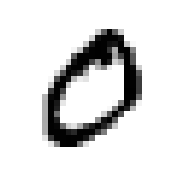

In [16]:
x.show()
print(y,x.shape)

In [17]:
a= rand_pad(padding=3, size=28, mode='zeros')
type(a)

list

In [18]:
#get_transforms returns a tuple of two lists of transforms: one for the training set and one for the validation 
#set (we don't want to modify the pictures in the validation set, so the second list of transforms is limited to 
#resizing the pictures).
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], []) #
tfms

([RandTransform(tfm=TfmPixel (pad), kwargs={'padding': 3, 'mode': 'zeros'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (crop), kwargs={'size': 28, 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [])

In [19]:
ll = ll.transform(tfms)
type(ll.transform)

method

In [20]:
bs = 128

In [21]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [22]:
x,y = data.train_ds[0]

0


(None, None, None)

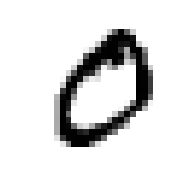

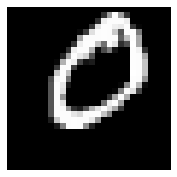

In [23]:
x.show(),data.train_ds[0][0].show(cmap='gray'),print(y)

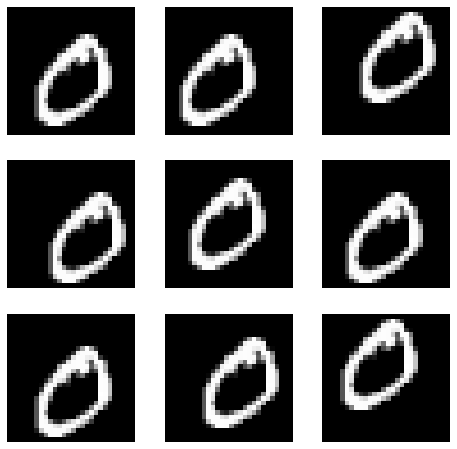

In [24]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [25]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

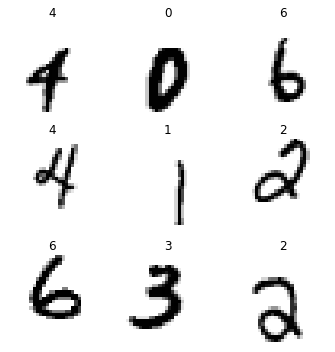

In [26]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [27]:
doc(nn.Conv2d)
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1) #ni:number of input channel, nf:no. of output channel

In [28]:
model = nn.Sequential(
    conv(1, 8), # 8*14*14 
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4  from 7 to 4 it did math.ceiling(7/2)
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [29]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [30]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [31]:
xb = xb.cuda()

In [32]:
model(xb).shape

torch.Size([128, 10])

In [33]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


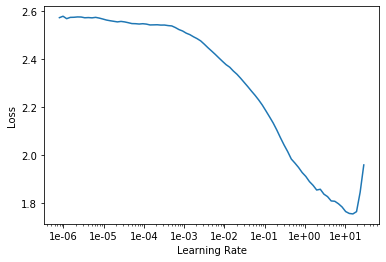

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.219230,0.223986,0.929700,01:06
1,0.125320,0.061577,0.981700,00:55
2,0.074156,0.041240,0.986300,00:54


### Refactor

In [36]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [37]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [38]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [39]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.229780,0.171323,0.948600,00:54
1,0.177531,0.139969,0.956400,00:54
2,0.157725,0.180223,0.941600,00:54
3,0.134952,0.291984,0.903700,00:53
4,0.120343,0.189970,0.943200,00:52
5,0.099314,0.074003,0.977400,00:53
6,0.085326,0.039472,0.987000,00:56
7,0.065261,0.034273,0.988600,00:54
8,0.041974,0.027803,0.990900,00:52
9,0.047826,0.026376,0.991700,00:54


### Resnet-ish

In [40]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [41]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [42]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [43]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [44]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [45]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


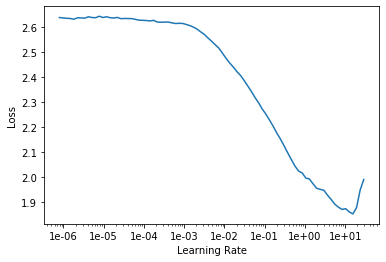

In [46]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.216944,0.150012,0.957400,00:59
1,0.141934,0.118003,0.963200,00:59
2,0.101224,0.152797,0.949400,01:00
3,0.086879,0.074663,0.975300,01:02
4,0.067816,0.045225,0.986000,00:59
5,0.061049,0.053639,0.985100,00:59
6,0.052576,0.045072,0.986500,00:59
7,0.041167,0.028812,0.990700,00:59
8,0.032013,0.024017,0.993000,01:01
9,0.028773,0.021076,0.993900,00:59


In [48]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

## fin